## Project Milestone 3

### 1) Load the data, clean it again before starting to work. 

In [1]:
# Some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import ast
import re
import seaborn as sns 
from statsmodels.stats import diagnostic
from scipy import stats
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# load the data and delete nan
final_dataset_df_path = 'data/processed_data/success_movies.csv'
ethnicity_sucess_df = pd.read_csv(final_dataset_df_path)
ethnicity_sucess_df =ethnicity_sucess_df.dropna(subset=['diversity'])
ethnicity_sucess_df.head()

,Unnamed: 0,Movie_name,Movie_release_date,Ratings,Wikipedia_movie_ID,Actor_ethnicity,Movie_countries,Movie_box_office_revenue,Nomination,Success,diversity,actor_number
0,0,$,1971,6.3,4213160.0,Hungarian Americans,{'United States of America'},NaN,False,0,0.352956,1
1,1,$9.99,2008,6.7,20624798.0,Australians,"{'Australia', 'Israel'}",NaN,False,0,0.352956,1
2,2,'R Xmas,2001,5.7,24799628.0,Italian Americans,"{'France', 'United States of America'}",NaN,False,0,1.901126,4
3,3,'Til There Was You,1997,4.8,17841580.0,Irish Americans,{'United States of America'},NaN,False,0,0.270557,7
4,4,'Til We Meet Again,1940,6.7,16038391.0,Irish Americans,{'United States of America'},NaN,False,0,0.950563,2


In [4]:
ethnicity_sucess_df= ethnicity_sucess_df[ethnicity_sucess_df["actor_number"] != 1]
ethnicity_sucess_df.head()

,Unnamed: 0,Movie_name,Movie_release_date,Ratings,Wikipedia_movie_ID,Actor_ethnicity,Movie_countries,Movie_box_office_revenue,Nomination,Success,diversity,actor_number
2,2,'R Xmas,2001,5.7,24799628.0,Italian Americans,"{'France', 'United States of America'}",NaN,False,0,1.901126,4
3,3,'Til There Was You,1997,4.8,17841580.0,Irish Americans,{'United States of America'},NaN,False,0,0.270557,7
4,4,'Til We Meet Again,1940,6.7,16038391.0,Irish Americans,{'United States of America'},NaN,False,0,0.950563,2
5,5,"'night, Mother",1986,7.6,8098268.0,Czech Americans,{'United States of America'},NaN,False,1,0.176478,2
6,6,(Untitled),2009,6.3,24204980.0,Jewish people,{'United States of America'},NaN,False,0,0.620383,3


### 2) Explore the data, get to know the data

What is the distribution of our diversity score? question is it normal that diversity score goes up to 2.5 or is it supposed to be between 0 and 1?

/var/folders/w7/t9sglxkj5nz7xv4mxk5dftlh0000gn/T/ipykernel_2884/1076679750.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


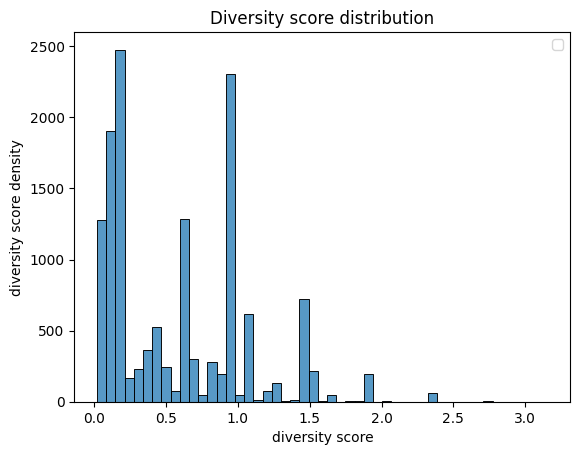

In [5]:
# plot histogram of the distribution of diversity scores
ax= sns.histplot(ethnicity_sucess_df['diversity'])
ax.set(title='Diversity score distribution',xlabel='diversity score', ylabel='diversity score density')
plt.legend()
plt.show()

In [6]:
import plotly.express as px
fig = px.histogram(ethnicity_sucess_df['diversity'], x="diversity")
fig.show()

In [7]:
# basic statistics
ethnicity_sucess_df.diversity.describe()

count    13837.000000
mean         0.578456
std          0.484140
min          0.018577
25%          0.176478
50%          0.452806
75%          0.950563
max          3.157514
Name: diversity, dtype: float64

How does the diversity score evolves over time? 

/var/folders/w7/t9sglxkj5nz7xv4mxk5dftlh0000gn/T/ipykernel_2884/1337128289.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Text(0, 0.5, 'Diversity Score')

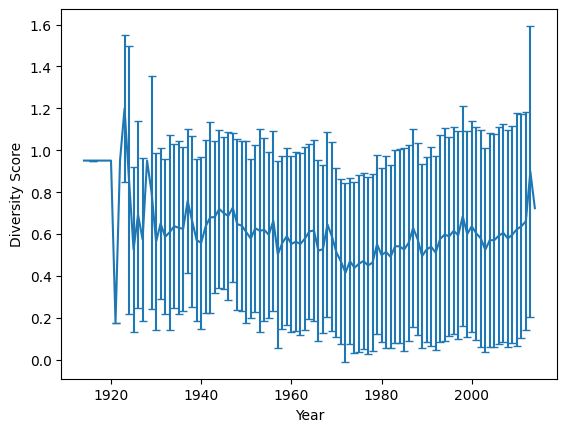

In [8]:
diversity_by_year = ethnicity_sucess_df.groupby(ethnicity_sucess_df['Movie_release_date']).apply(lambda x: pd.Series({
        'average_diversity': x['diversity'].mean(),
        'std_diversity': x['diversity'].std()
    }))	

plt.errorbar(diversity_by_year.index, diversity_by_year.average_diversity,
             yerr = diversity_by_year.std_diversity,
             capsize= 3)
plt.xlabel('Year')
plt.ylabel('Diversity Score')

### 3) Hypothesis testing

Is diversity higher in sucessful movies compared to less successful movies ?

In [9]:
diversite_nomination_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Nomination'] == True]['diversity'].mean()
diversite_box_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] > 38119483]['diversity'].mean()
diversite_ratings_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Ratings'] > 7.5 ]['diversity'].mean()
diversite_overall_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 1]['diversity'].mean()

print(f"Average diversity for film nominated:{diversite_nomination_1:.4f}")
print(f"Average diversity for film with high box revenue:{diversite_box_1:.4f}")
print(f"Average diversity for film with high ratings:{diversite_ratings_1:.4f}")
print(f"Average diversity for film sucessful :{diversite_overall_1:.4f}")


Average diversity for film nominated:0.6391
Average diversity for film with high box revenue:0.5760
Average diversity for film with high ratings:0.4906
Average diversity for film sucessful :0.5114


In [10]:
diversite_nomination_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Nomination'] == False]['diversity'].mean()
diversite_box_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] <= 38119483]['diversity'].mean()
diversite_ratings_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Ratings'] <= 7.5 ]['diversity'].mean()
diversite_overall_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 0]['diversity'].mean()

print(f"Average diversity for film not nominated:{diversite_nomination_0:.4f}")
print(f"Average diversity for film with lower box revenue:{diversite_box_0:.4f}")
print(f"Average diversity for film with lower ratings:{diversite_ratings_0:.4f}")
print(f"Average diversity for film less sucessful :{diversite_overall_0:.4f}")

Average diversity for film not nominated:0.5672
Average diversity for film with lower box revenue:0.5963
Average diversity for film with lower ratings:0.5870
Average diversity for film less sucessful :0.5869


The diversity factor seems slightly higher for film with lower box revenue, lower ratings, overall. Diversity factor only seems higher for film nominated. 

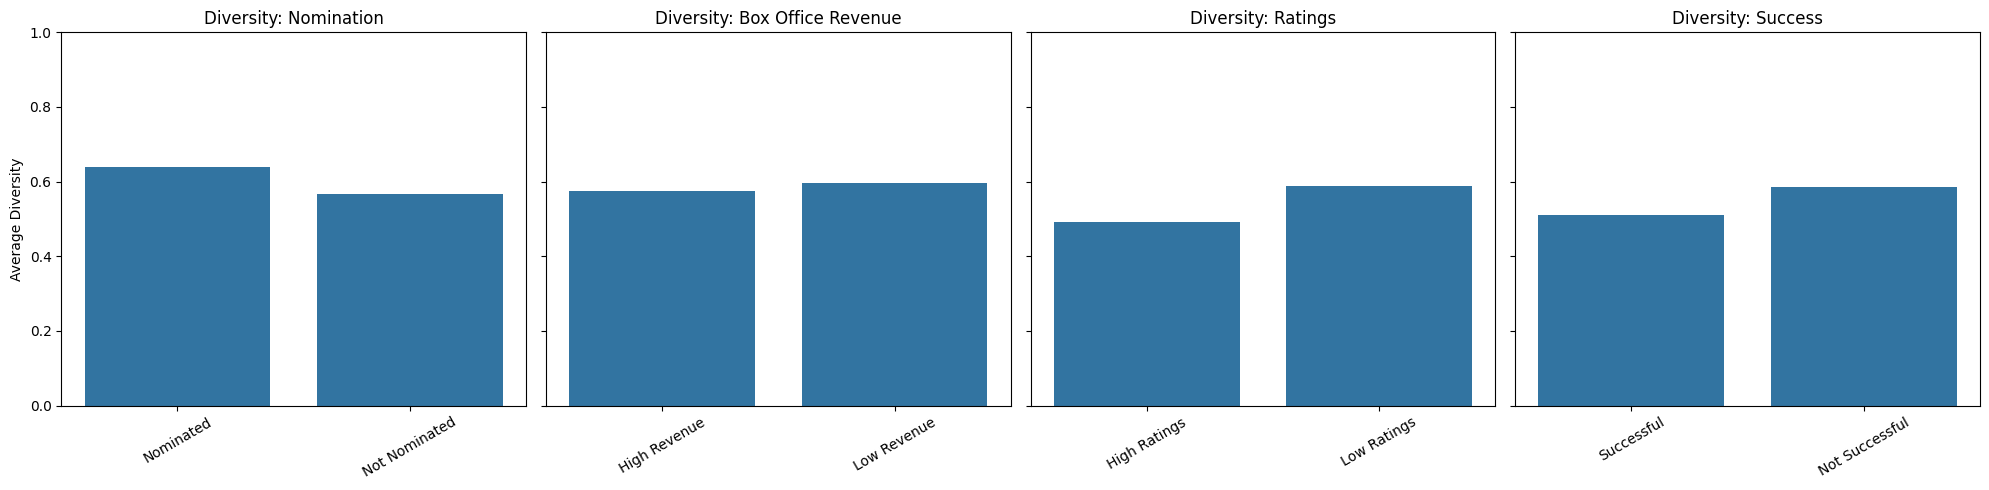

In [11]:
categories = ['Nominated', 'Not Nominated']
diversity_nomination = [diversite_nomination_1, diversite_nomination_0]

categories_box = ['High Revenue', 'Low Revenue']
diversity_box = [diversite_box_1, diversite_box_0]

categories_ratings = ['High Ratings', 'Low Ratings']
diversity_ratings = [diversite_ratings_1, diversite_ratings_0]

categories_success = ['Successful', 'Not Successful']
diversity_success = [diversite_overall_1, diversite_overall_0]

# Create the figure and subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# First plot: Nomination
sns.barplot(x=categories,y=diversity_nomination,ax=axes[0])
axes[0].set_title('Diversity: Nomination')
axes[0].set_ylabel('Average Diversity')
axes[0].set_ylim(0, 1)  # Adjust based on your diversity score range
axes[0].set_xticks(range(len(categories)))
axes[0].set_xticklabels(categories, rotation=30)

# Second plot: Box Office Revenue
sns.barplot(x=categories_box,y=diversity_box,ax=axes[1])
axes[1].set_title('Diversity: Box Office Revenue')
axes[1].set_xticks(range(len(categories_box)))
axes[1].set_xticklabels(categories_box, rotation=30)

# Third plot: Ratings
sns.barplot(x=categories_ratings,y=diversity_ratings,ax=axes[2])
axes[2].set_title('Diversity: Ratings')
axes[2].set_xticks(range(len(categories_ratings)))
axes[2].set_xticklabels(categories_ratings, rotation=30)

# Fourth plot: Success
sns.barplot(x=categories_success,y=diversity_success,ax=axes[3])
axes[3].set_title('Diversity: Success')
axes[3].set_xticks(range(len(categories_success)))
axes[3].set_xticklabels(categories_success, rotation=30)

# Adjust layout
plt.tight_layout()
plt.show()


Is this difference significant?  Let's do a t-test.

In [12]:
t_test_sucess=stats.ttest_ind(ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 1]['diversity'], ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 0]['diversity'])
t_test_nomination=stats.ttest_ind(ethnicity_sucess_df.loc[ethnicity_sucess_df['Nomination'] == True]['diversity'], ethnicity_sucess_df.loc[ethnicity_sucess_df['Nomination'] == False]['diversity'])
t_test_box=stats.ttest_ind(ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] > 38119483]['diversity'], ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] <= 38119483]['diversity'])
t_test_ratings=stats.ttest_ind(ethnicity_sucess_df.loc[ethnicity_sucess_df['Ratings'] > 7.5 ]['diversity'], ethnicity_sucess_df.loc[ethnicity_sucess_df['Ratings'] <= 7.5 ]['diversity'])

print(f"Success:{t_test_sucess}")
print(f"Nomination:{t_test_nomination}")
print(f"Box revenue:{t_test_box}")
print(f"Ratings:{t_test_ratings}")

Success:TtestResult(statistic=np.float64(-5.785843030083439), pvalue=np.float64(7.371103860721943e-09), df=np.float64(13835.0))
Nomination:TtestResult(statistic=np.float64(6.342479099595016), pvalue=np.float64(2.331273905599801e-10), df=np.float64(13835.0))
Box revenue:TtestResult(statistic=np.float64(-0.6685528464289106), pvalue=np.float64(0.5038935508242095), df=np.float64(1368.0))
Ratings:TtestResult(statistic=np.float64(-6.6631441678085075), pvalue=np.float64(2.7816934841029143e-11), df=np.float64(13835.0))


The p-value is smaller than 0.05 for success, nomination and ratings. Therefore we can reject the null hypothesis that the diversity accross the sucessful and less succesful movies is the same. There is a significant difference. 
However, the pvalue is larger than 0.05 for box office revenue. Therefore we can accept the null hypothesis that the diversity accross the sucessful and less succesful movies is the same. There is not a significant difference.  

### 4) Examining relationship between two variables 

In [13]:
#number_nan_box=ethnicity_sucess_df['Movie_box_office_revenue'].isna().sum()
#print(number_nan_box)

In [14]:
#ethnicity_sucess_df =ethnicity_sucess_df.dropna(subset=['Movie_box_office_revenue'])

In [15]:
#length=len(ethnicity_sucess_df)
#print(length)
#test_box=stats.pearsonr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Movie_box_office_revenue'])
#print(f"Box revenue:{test_box}")
#s_test_box=stats.spearmanr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Movie_box_office_revenue'])
#print(f"Box revenue:{s_test_box}")

In [16]:
test_success=stats.pearsonr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Success'])
test_ratings=stats.pearsonr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Ratings'])
test_box=stats.pearsonr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Movie_box_office_revenue'])
test_nomination=stats.pearsonr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Nomination'])

print(f"Success:{test_success}")
print(f"Nomination:{test_nomination}")
print(f"Box revenue:{test_box}")
print(f"Ratings:{test_ratings}")

Success:PearsonRResult(statistic=np.float64(-0.04913062373592212), pvalue=np.float64(7.371103860721352e-09))
Nomination:PearsonRResult(statistic=np.float64(0.05384420829532697), pvalue=np.float64(2.331273905599716e-10))
Box revenue:PearsonRResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Ratings:PearsonRResult(statistic=np.float64(-0.01620142617834005), pvalue=np.float64(0.05668404195699037))


Correlation significant. Weak negative association. More diversity - less success. 

In [17]:
s_test_success=stats.spearmanr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Success'])
s_test_ratings=stats.spearmanr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Ratings'])
s_test_box=stats.spearmanr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Movie_box_office_revenue'])
s_test_nomination=stats.spearmanr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Nomination'])

print(f"Success:{s_test_success}")
print(f"Nomination:{s_test_nomination}")
print(f"Box revenue:{s_test_box}")
print(f"Ratings:{s_test_ratings}")

Success:SignificanceResult(statistic=np.float64(-0.054888744652983344), pvalue=np.float64(1.0408685217974587e-10))
Nomination:SignificanceResult(statistic=np.float64(0.07275896758602955), pvalue=np.float64(1.041344475652701e-17))
Box revenue:SignificanceResult(statistic=nan, pvalue=nan)
Ratings:SignificanceResult(statistic=np.float64(-0.02375449447583146), pvalue=np.float64(0.0051995877071002354))


Correlation significant for sucess overall, nomination and ratings. 
Success and ratings- weak negative association. 
nomination - weak positive association. 

## 5) How do we set the threshold to define how successful is a film

#### The effect of changing the threshold for ratings 

In [18]:
ethnicity_sucess_df.Ratings.describe()

count    13837.000000
mean         6.201778
std          1.091420
min          1.200000
25%          5.600000
50%          6.300000
75%          7.000000
max          9.300000
Name: Ratings, dtype: float64

In [19]:
ethnicity_sucess_df['Success'] = (ethnicity_sucess_df['Ratings'] > 6.9) | (ethnicity_sucess_df['Nomination'] == 'True') | (ethnicity_sucess_df['Movie_box_office_revenue'] > 38119483)

In [20]:
number_successful_movies = ethnicity_sucess_df['Success'].sum()
proportion_success_movies=number_successful_movies/len(ethnicity_sucess_df) *100
print(proportion_success_movies)

27.455373274553736


In [21]:
diversite_ratings_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Ratings'] > 6.9 ]['diversity'].mean()
diversite_overall_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 1]['diversity'].mean()
print(f"Average diversity for film with high ratings:{diversite_ratings_1:.4f}")
print(f"Average diversity for film sucessful :{diversite_overall_1:.4f}")
diversite_ratings_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Ratings'] <= 6.9 ]['diversity'].mean()
diversite_overall_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 0]['diversity'].mean()
print(f"Average diversity for film with lower ratings:{diversite_ratings_0:.4f}")
print(f"Average diversity for film less sucessful :{diversite_overall_0:.4f}")

Average diversity for film with high ratings:0.5113
Average diversity for film sucessful :0.5185
Average diversity for film with lower ratings:0.6015
Average diversity for film less sucessful :0.6012


In [22]:
ethnicity_sucess_df['Success'] = (ethnicity_sucess_df['Ratings'] > 7.2) | (ethnicity_sucess_df['Nomination'] == 'True') | (ethnicity_sucess_df['Movie_box_office_revenue'] > 38119483)
number_successful_movies = ethnicity_sucess_df['Success'].sum()
proportion_success_movies=number_successful_movies/len(ethnicity_sucess_df) *100
print(proportion_success_movies)

17.98800317988003


In [23]:
diversite_ratings_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Ratings'] > 7.2 ]['diversity'].mean()
diversite_overall_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 1]['diversity'].mean()
print(f"Average diversity for film with high ratings:{diversite_ratings_1:.4f}")
print(f"Average diversity for film sucessful :{diversite_overall_1:.4f}")
diversite_ratings_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Ratings'] <= 7.2 ]['diversity'].mean()
diversite_overall_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 0]['diversity'].mean()
print(f"Average diversity for film with lower ratings:{diversite_ratings_0:.4f}")
print(f"Average diversity for film less sucessful :{diversite_overall_0:.4f}")

Average diversity for film with high ratings:0.4922
Average diversity for film sucessful :0.5057
Average diversity for film with lower ratings:0.5947
Average diversity for film less sucessful :0.5944


In [24]:
ethnicity_sucess_df['Success'] = (ethnicity_sucess_df['Ratings'] > 8) | (ethnicity_sucess_df['Nomination'] == 'True') | (ethnicity_sucess_df['Movie_box_office_revenue'] > 38119483)
number_successful_movies = ethnicity_sucess_df['Success'].sum()
proportion_success_movies=number_successful_movies/len(ethnicity_sucess_df) *100
print(proportion_success_movies)

4.93604104936041


In [25]:
diversite_ratings_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Ratings'] > 8 ]['diversity'].mean()
diversite_overall_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 1]['diversity'].mean()
print(f"Average diversity for film with high ratings:{diversite_ratings_1:.4f}")
print(f"Average diversity for film sucessful :{diversite_overall_1:.4f}")
diversite_ratings_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Ratings'] <= 8 ]['diversity'].mean()
diversite_overall_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 0]['diversity'].mean()
print(f"Average diversity for film with lower ratings:{diversite_ratings_0:.4f}")
print(f"Average diversity for film less sucessful :{diversite_overall_0:.4f}")

Average diversity for film with high ratings:0.4549
Average diversity for film sucessful :0.5177
Average diversity for film with lower ratings:0.5815
Average diversity for film less sucessful :0.5816


In [26]:
# à refaire. 
# Plotting the Average Diversity of Successful Films vs Ratings Threshold

plt.figure(figsize=(12, 6))
ratings_thresholds = np.arange(6.5, 8.5, 0.1)
# Plot average diversity of successful films for different ratings thresholds
plt.plot(ratings_thresholds, diversity_successful, label='Avg Diversity (Successful Movies)', marker='s', color='orange')

# Customize the plot
plt.title('Average Diversity of Successful Movies vs Ratings Threshold', fontsize=14)
plt.xlabel('Ratings Threshold', fontsize=12)
plt.ylabel('Average Diversity of Successful Movies', fontsize=12)
#plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
plt.legend(fontsize=10)
#plt.grid(alpha=0.3)
plt.show()


NameError: name 'diversity_successful' is not defined

<Figure size 1200x600 with 0 Axes>

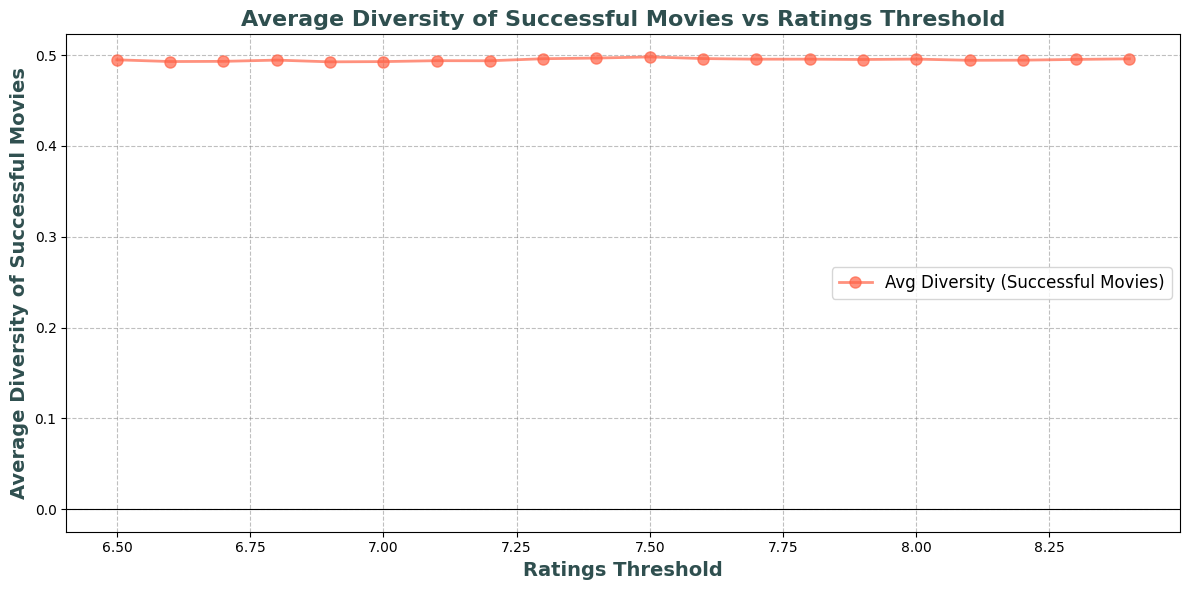

In [59]:
import matplotlib.pyplot as plt

# Improved plot with more aesthetics
plt.figure(figsize=(12, 6))

# Plot average diversity of successful films with a refined color and style
plt.plot(ratings_thresholds, diversity_successful, 
         label='Avg Diversity (Successful Movies)', 
         marker='o', color='#FF6347', markersize=8, linestyle='-', linewidth=2, alpha=0.7)

# Title with larger font size and bold text
plt.title('Average Diversity of Successful Movies vs Ratings Threshold', fontsize=16, fontweight='bold', color='#2F4F4F')

# Labels with increased font size and clear style
plt.xlabel('Ratings Threshold', fontsize=14, fontweight='bold', color='#2F4F4F')
plt.ylabel('Average Diversity of Successful Movies', fontsize=14, fontweight='bold', color='#2F4F4F')

# Customizing the grid (lighter lines)
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

# Adding a horizontal line for better visual guidance
plt.axhline(y=0, color='black', linewidth=0.8)

# Adding the legend with larger font size
plt.legend(fontsize=12)

# Display the plot
plt.tight_layout()  # Adjust the layout to avoid clipping
plt.show()


### The effect of changing the threshold for box_office_revenue 

In [27]:
ethnicity_sucess_df['Movie_box_office_revenue'].describe()

count    1.370000e+03
mean     4.751979e+07
std      1.013779e+08
min      1.123800e+04
25%      2.050668e+06
50%      9.992062e+06
75%      3.944789e+07
max      9.198388e+08
Name: Movie_box_office_revenue, dtype: float64

In [28]:
ethnicity_sucess_df['Success'] = (ethnicity_sucess_df['Ratings'] > 7.5) | (ethnicity_sucess_df['Nomination'] == 'True') | (ethnicity_sucess_df['Movie_box_office_revenue'] > 23963802.0)
number_successful_movies = ethnicity_sucess_df['Success'].sum()
proportion_success_movies=number_successful_movies/len(ethnicity_sucess_df) *100
print(proportion_success_movies)

11.917323119173231


In [29]:
diversite_ratings_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] > 23963802.0 ]['diversity'].mean()
diversite_overall_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 1]['diversity'].mean()
print(f"Average diversity for film with high ratings:{diversite_ratings_1:.4f}")
print(f"Average diversity for film sucessful :{diversite_overall_1:.4f}")
diversite_ratings_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] <= 23963802.0 ]['diversity'].mean()
diversite_overall_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 0]['diversity'].mean()
print(f"Average diversity for film with lower ratings:{diversite_ratings_0:.4f}")
print(f"Average diversity for film less sucessful :{diversite_overall_0:.4f}")

Average diversity for film with high ratings:0.5895
Average diversity for film sucessful :0.5197
Average diversity for film with lower ratings:0.5918
Average diversity for film less sucessful :0.5864


In [30]:
t_test_box=stats.ttest_ind(ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] > 23963802.0]['diversity'], ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] <= 23963802.0]['diversity'])
print(f"Box revenue:{t_test_box}")

Box revenue:TtestResult(statistic=np.float64(-0.08110567140680656), pvalue=np.float64(0.9353697792344504), df=np.float64(1368.0))


In [31]:
ethnicity_sucess_df['Success'] = (ethnicity_sucess_df['Ratings'] > 7.5) | (ethnicity_sucess_df['Nomination'] == 'True') | (ethnicity_sucess_df['Movie_box_office_revenue'] > 482083290)
number_successful_movies = ethnicity_sucess_df['Success'].sum()
proportion_success_movies=number_successful_movies/len(ethnicity_sucess_df) *100
print(proportion_success_movies)

8.96870708968707


In [32]:
diversite_ratings_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] > 482083290 ]['diversity'].mean()
diversite_overall_1=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 1]['diversity'].mean()
print(f"Average diversity for film with high ratings:{diversite_ratings_1:.4f}")
print(f"Average diversity for film sucessful :{diversite_overall_1:.4f}")
diversite_ratings_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] <= 482083290 ]['diversity'].mean()
diversite_overall_0=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 0]['diversity'].mean()
print(f"Average diversity for film with lower ratings:{diversite_ratings_0:.4f}")
print(f"Average diversity for film less sucessful :{diversite_overall_0:.4f}")

Average diversity for film with high ratings:0.6246
Average diversity for film sucessful :0.4923
Average diversity for film with lower ratings:0.5906
Average diversity for film less sucessful :0.5869


In [33]:
t_test_box=stats.ttest_ind(ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] > 482083290]['diversity'], ethnicity_sucess_df.loc[ethnicity_sucess_df['Movie_box_office_revenue'] <= 482083290]['diversity'])
print(f"Box revenue:{t_test_box}")

Box revenue:TtestResult(statistic=np.float64(0.2746984681439098), pvalue=np.float64(0.7835893860099428), df=np.float64(1368.0))


In [ ]:
import matplotlib.pyplot as plt

# Improved plot with more aesthetics
plt.figure(figsize=(12, 6))

# Plot average diversity of successful films with a refined color and style
plt.plot(box_office_revenue_thresholds, diversity_successful, 
         label='Avg Diversity (Successful Movies)', 
         marker='o', color='#FF6347', markersize=8, linestyle='-', linewidth=2, alpha=0.7)

# Title with larger font size and bold text
plt.title('Average Diversity of Successful Movies vs Ratings Threshold', fontsize=16, fontweight='bold', color='#2F4F4F')

# Labels with increased font size and clear style
plt.xlabel('Ratings Threshold', fontsize=14, fontweight='bold', color='#2F4F4F')
plt.ylabel('Average Diversity of Successful Movies', fontsize=14, fontweight='bold', color='#2F4F4F')

# Customizing the grid (lighter lines)
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

# Adding a horizontal line for better visual guidance
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')

# Adding the legend with larger font size
plt.legend(fontsize=12)

# Display the plot
plt.tight_layout()  # Adjust the layout to avoid clipping
plt.show()

## 6) Propensity score matching. 

Many confounders can influence the success of a film. Let's try to isolate the effect of diversity on the sucess of a film. Treatment is diversity. Considered as treated if the diversity score is superior to 0.365256. control if the diversity score is inferior to 0.365256. 

In [34]:
treated = ethnicity_sucess_df.loc[ethnicity_sucess_df['diversity'] >= 0.365256] 
control = ethnicity_sucess_df.loc[ethnicity_sucess_df['diversity'] <= 0.365256]

By completing the paired matching, we try to compare movies with similar probability of receiving the treatment, which in our case is an ethnicity score. We used logistic regression to compute the propensity score based on the movie runtime, the year the movie was released, the number of languages present, and the number of countries the film producing the film.

In [35]:
movie_metadata_path = 'data/raw_data/movie.metadata.tsv'
movie_metadata = pd.read_csv(movie_metadata_path, sep='\t')

In [36]:
new_column_names_m = [
    "Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages",
    "Movie_countries",
    "Movie_genres"
]

# Rename the columns by directly setting DataFrame.columns
movie_metadata.columns = new_column_names_m

In [37]:
# Remaining rows:
columns_to_check = ['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']
remaining_rows = {col: movie_metadata[col].dropna().shape[0] for col in columns_to_check}
# Print the results
for col, count in remaining_rows.items():
    print(f"Remaining rows for '{col}': {count}")

# Drop the rows where na
filtered_movie = movie_metadata[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Wikipedia_movie_ID'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_name'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_release_date'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_countries'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_runtime'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_languages'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_genres'])
# Display the updated DataFrame
display(filtered_movie)

Remaining rows for 'Wikipedia_movie_ID': 81740
Remaining rows for 'Movie_name': 81740
Remaining rows for 'Movie_release_date': 74838
Remaining rows for 'Movie_runtime': 61290
Remaining rows for 'Movie_languages': 81740
Remaining rows for 'Movie_countries': 81740
Remaining rows for 'Movie_genres': 81740


,Wikipedia_movie_ID,Movie_name,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,28463795,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
2,9363483,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
3,261236,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
4,13696889,The Gangsters,1913-05-29,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
...,...,...,...,...,...,...,...
81735,35228177,Mermaids: The Body Found,2011-03-19,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81736,34980460,Knuckle,2011-01-21,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81737,9971909,Another Nice Mess,1972-09-22,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81738,913762,The Super Dimension Fortress Macross II: Lover...,1992-05-21,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [38]:
# Convert strings to dictionaries
filtered_movie['Movie_countries'] = filtered_movie['Movie_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now count the empty dictionaries
empty_dict_count = filtered_movie['Movie_countries'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()
print(f"Number of empty dictionaries: {empty_dict_count}") # 139

# Need to drop the row where the country is not known (empty dictionnary)
filtered_movie = filtered_movie[filtered_movie['Movie_countries'].apply(lambda x: isinstance(x, dict) and len(x) > 0)] # 8261

# Convert strings to dictionaries
filtered_movie['Movie_genres'] = filtered_movie['Movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now count the empty dictionaries
empty_dict_count = filtered_movie['Movie_genres'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()
print(f"Number of empty dictionaries: {empty_dict_count}") # 139

# Need to drop the row where the country is not known (empty dictionnary)
filtered_movie = filtered_movie[filtered_movie['Movie_genres'].apply(lambda x: isinstance(x, dict) and len(x) > 0)] # 8261

# Convert strings to dictionaries
filtered_movie['Movie_languages'] = filtered_movie['Movie_languages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now count the empty dictionaries
empty_dict_count = filtered_movie['Movie_languages'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()
print(f"Number of empty dictionaries: {empty_dict_count}") # 139

# Need to drop the row where the country is not known (empty dictionnary)
filtered_movie = filtered_movie[filtered_movie['Movie_languages'].apply(lambda x: isinstance(x, dict) and len(x) > 0)] # 8261



Number of empty dictionaries: 2560
Number of empty dictionaries: 347
Number of empty dictionaries: 4840


In [39]:
# Clean country column with only the names of the countries

# Extract only the country names and store them as a set
filtered_movie.loc[:, 'Movie_countries'] = filtered_movie['Movie_countries'].apply(
    lambda x: set(x.values()) if isinstance(x, dict) else set()
)
# Extract only the country names and store them as a set
filtered_movie.loc[:, 'Movie_genres'] = filtered_movie['Movie_genres'].apply(
    lambda x: set(x.values()) if isinstance(x, dict) else set()
)
# Extract only the country names and store them as a set
filtered_movie.loc[:, 'Movie_languages'] = filtered_movie['Movie_languages'].apply(
    lambda x: set(x.values()) if isinstance(x, dict) else set()
)
display(filtered_movie)

,Wikipedia_movie_ID,Movie_name,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,{English Language},{United States of America},"{Crime Drama, Biographical film, Mystery, Drama}"
1,28463795,Brun bitter,1988,83.0,{Norwegian Language},{Norway},"{Crime Fiction, Drama}"
2,9363483,White Of The Eye,1987,110.0,{English Language},{United Kingdom},"{Psychological thriller, Erotic thriller, Thri..."
3,261236,A Woman in Flames,1983,106.0,{German Language},{Germany},{Drama}
4,13696889,The Gangsters,1913-05-29,35.0,"{English Language, Silent film}",{United States of America},"{Black-and-white, Short Film, Comedy, Indie, S..."
...,...,...,...,...,...,...,...
81735,35228177,Mermaids: The Body Found,2011-03-19,120.0,{English Language},{United States of America},{Drama}
81736,34980460,Knuckle,2011-01-21,96.0,{English Language},"{United Kingdom, Ireland}","{Biographical film, Drama, Documentary}"
81737,9971909,Another Nice Mess,1972-09-22,66.0,{English Language},{United States of America},"{Satire, Comedy}"
81738,913762,The Super Dimension Fortress Macross II: Lover...,1992-05-21,150.0,{Japanese Language},{Japan},"{Japanese Movies, Drama, Anime, Short Film, An..."


In [40]:
# Now we clean release date:
# (as we see that there is several ways to write the date and that there are missing values)

# We need to clean release date (as we see that there is several ways to write the date)
filtered_movie.loc[:,'Movie_release_date'] = filtered_movie['Movie_release_date'].astype(str).str[:4]

# Display the updated DataFrame
display(filtered_movie)

,Wikipedia_movie_ID,Movie_name,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,95.0,{English Language},{United States of America},"{Crime Drama, Biographical film, Mystery, Drama}"
1,28463795,Brun bitter,1988,83.0,{Norwegian Language},{Norway},"{Crime Fiction, Drama}"
2,9363483,White Of The Eye,1987,110.0,{English Language},{United Kingdom},"{Psychological thriller, Erotic thriller, Thri..."
3,261236,A Woman in Flames,1983,106.0,{German Language},{Germany},{Drama}
4,13696889,The Gangsters,1913,35.0,"{English Language, Silent film}",{United States of America},"{Black-and-white, Short Film, Comedy, Indie, S..."
...,...,...,...,...,...,...,...
81735,35228177,Mermaids: The Body Found,2011,120.0,{English Language},{United States of America},{Drama}
81736,34980460,Knuckle,2011,96.0,{English Language},"{United Kingdom, Ireland}","{Biographical film, Drama, Documentary}"
81737,9971909,Another Nice Mess,1972,66.0,{English Language},{United States of America},"{Satire, Comedy}"
81738,913762,The Super Dimension Fortress Macross II: Lover...,1992,150.0,{Japanese Language},{Japan},"{Japanese Movies, Drama, Anime, Short Film, An..."


In [41]:
# Now we clean movie names
# It appears that the same movie name can appear several time

# Convert 'Movie_countries' to a string representation for grouping
filtered_movie.loc[:,'Movie_countries_str'] = filtered_movie['Movie_countries'].apply(lambda x: ', '.join(sorted(x)) if isinstance(x, set) else str(x))
# Convert 'Movie_countries' to a string representation for grouping
filtered_movie.loc[:,'Movie_languages_str'] = filtered_movie['Movie_languages'].apply(lambda x: ', '.join(sorted(x)) if isinstance(x, set) else str(x))

# Convert 'Movie_countries' to a string representation for grouping
filtered_movie.loc[:,'Movie_genres_str'] = filtered_movie['Movie_genres'].apply(lambda x: ', '.join(sorted(x)) if isinstance(x, set) else str(x))
filtered_movie

,Wikipedia_movie_ID,Movie_name,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_countries_str,Movie_languages_str,Movie_genres_str
0,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,95.0,{English Language},{United States of America},"{Crime Drama, Biographical film, Mystery, Drama}",United States of America,English Language,"Biographical film, Crime Drama, Drama, Mystery"
1,28463795,Brun bitter,1988,83.0,{Norwegian Language},{Norway},"{Crime Fiction, Drama}",Norway,Norwegian Language,"Crime Fiction, Drama"
2,9363483,White Of The Eye,1987,110.0,{English Language},{United Kingdom},"{Psychological thriller, Erotic thriller, Thri...",United Kingdom,English Language,"Erotic thriller, Psychological thriller, Thriller"
3,261236,A Woman in Flames,1983,106.0,{German Language},{Germany},{Drama},Germany,German Language,Drama
4,13696889,The Gangsters,1913,35.0,"{English Language, Silent film}",{United States of America},"{Black-and-white, Short Film, Comedy, Indie, S...",United States of America,"English Language, Silent film","Black-and-white, Comedy, Indie, Short Film, Si..."
...,...,...,...,...,...,...,...,...,...,...
81735,35228177,Mermaids: The Body Found,2011,120.0,{English Language},{United States of America},{Drama},United States of America,English Language,Drama
81736,34980460,Knuckle,2011,96.0,{English Language},"{United Kingdom, Ireland}","{Biographical film, Drama, Documentary}","Ireland, United Kingdom",English Language,"Biographical film, Documentary, Drama"
81737,9971909,Another Nice Mess,1972,66.0,{English Language},{United States of America},"{Satire, Comedy}",United States of America,English Language,"Comedy, Satire"
81738,913762,The Super Dimension Fortress Macross II: Lover...,1992,150.0,{Japanese Language},{Japan},"{Japanese Movies, Drama, Anime, Short Film, An...",Japan,Japanese Language,"Adventure, Animation, Anime, Drama, Japanese M..."


In [42]:
# Group by 'Movie_name', 'Wikipedia_movie_ID', 'Movie_release_date', and 'Movie_countries_str'
merged_filtered_movie_test = (
    filtered_movie.groupby(['Movie_name', 'Wikipedia_movie_ID', 'Movie_release_date', 'Movie_runtime','Movie_countries_str','Movie_languages_str','Movie_genres_str'], as_index=False)
    .agg({'Movie_countries_str': 'first'})  # Retain the merged string representation
)

# Rename the column back to 'Movie_countries' for consistency
merged_filtered_movie_test = merged_filtered_movie_test.rename(columns={'Movie_countries_str': 'Movie_countries'})
merged_filtered_movie_test = merged_filtered_movie_test.rename(columns={'Movie_languages_str': 'Movie_languages'})
merged_filtered_movie_test = merged_filtered_movie_test.rename(columns={'Movie_genres_str': 'Movie_genres'})
# Display the cleaned DataFrame
display(merged_filtered_movie_test)
merged_filtered_movie_test= merged_filtered_movie_test.drop(['Movie_genres'], axis=1)

,Movie_name,Wikipedia_movie_ID,Movie_release_date,Movie_runtime,Movie_languages,Movie_genres,Movie_countries
0,!Women Art Revolution,29988427,2010,83.0,English Language,"Documentary, History, LGBT","Canada, United States of America"
1,$,4213160,1971,119.0,English Language,"Action, Action/Adventure, Comedy, Crime Fictio...",United States of America
2,$9.99,20624798,2008,78.0,English Language,"Animation, Drama, Indie, Stop motion, World ci...","Australia, Israel"
3,'68,2250713,1988,98.0,English Language,"Coming of age, Drama, Family Drama, Period piece","Hungary, United States of America"
4,'Gator Bait,10331139,1974,91.0,English Language,"Action, Drama, Thriller",United States of America
...,...,...,...,...,...,...,...
50878,Žižek!,11033063,2005,71.0,English Language,"Biography, Culture & Society, Documentary, Med...","Canada, United States of America"
50879,Вчера,6077443,1988,84.0,Bulgarian Language,Drama,Bulgaria
50880,…All the Marbles,12680019,1981,113.0,English Language,"Comedy, Comedy-drama, Drama",United States of America
50881,…men Olsenbanden var ikke død,8277007,1984,89.0,Norwegian Language,"Comedy, Crime Fiction",Norway


In [43]:
merged_filtered_movie_test.dtypes
merged_filtered_movie_test['Movie_release_date'] = np.float64(merged_filtered_movie_test['Movie_release_date'])

In [44]:
ethnicity_sucess_df.head()

,Unnamed: 0,Movie_name,Movie_release_date,Ratings,Wikipedia_movie_ID,Actor_ethnicity,Movie_countries,Movie_box_office_revenue,Nomination,Success,diversity,actor_number
2,2,'R Xmas,2001,5.7,24799628.0,Italian Americans,"{'France', 'United States of America'}",NaN,False,False,1.901126,4
3,3,'Til There Was You,1997,4.8,17841580.0,Irish Americans,{'United States of America'},NaN,False,False,0.270557,7
4,4,'Til We Meet Again,1940,6.7,16038391.0,Irish Americans,{'United States of America'},NaN,False,False,0.950563,2
5,5,"'night, Mother",1986,7.6,8098268.0,Czech Americans,{'United States of America'},NaN,False,True,0.176478,2
6,6,(Untitled),2009,6.3,24204980.0,Jewish people,{'United States of America'},NaN,False,False,0.620383,3


In [45]:
ethnicity_sucess_df= ethnicity_sucess_df.drop(['Actor_ethnicity','Movie_countries'], axis=1)

In [46]:
ethnicity_sucess_df.dtypes

Unnamed: 0                    int64
Movie_name                   object
Movie_release_date            int64
Ratings                     float64
Wikipedia_movie_ID          float64
Movie_box_office_revenue    float64
Nomination                     bool
Success                        bool
diversity                   float64
actor_number                  int64
dtype: object

In [47]:
data=pd.merge(merged_filtered_movie_test,ethnicity_sucess_df,on= ['Wikipedia_movie_ID','Movie_name','Movie_release_date'], how='inner')
data.head()

,Movie_name,Wikipedia_movie_ID,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Unnamed: 0,Ratings,Movie_box_office_revenue,Nomination,Success,diversity,actor_number
0,'R Xmas,24799628,2001.0,83.0,"English Language, Spanish Language","France, United States of America",2,5.7,NaN,False,False,1.901126,4
1,'Til There Was You,17841580,1997.0,114.0,English Language,United States of America,3,4.8,NaN,False,False,0.270557,7
2,'Til We Meet Again,16038391,1940.0,99.0,"English Language, French Language, German Lang...",United States of America,4,6.7,NaN,False,False,0.950563,2
3,"'night, Mother",8098268,1986.0,97.0,English Language,United States of America,5,7.6,NaN,False,True,0.176478,2
4,*batteries not included,3762449,1987.0,107.0,English Language,United States of America,7,6.6,NaN,False,False,0.950563,2


In [48]:
data.sample(10)

,Movie_name,Wikipedia_movie_ID,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Unnamed: 0,Ratings,Movie_box_office_revenue,Nomination,Success,diversity,actor_number
4012,Heaven with a Gun,14430208,1969.0,101.0,English Language,United States of America,7115,6.3,NaN,False,False,0.950563,2
7064,Prometheus,31775043,2012.0,124.0,"English Language, Gaelic",United States of America,12816,7.0,NaN,True,False,1.446630,3
2732,Do the Right Thing,73428,1989.0,125.0,"English Language, Italian Language, Spanish La...",United States of America,4807,7.9,NaN,True,True,0.328378,12
5961,Monster House,2692284,2006.0,91.0,English Language,United States of America,10747,6.7,NaN,True,False,0.353013,5
6437,Nothing Like the Holidays,17203681,2008.0,99.0,English Language,United States of America,11643,6.1,NaN,False,False,1.505620,5
4171,Homegrown,11251963,1998.0,101.0,English Language,United States of America,7393,5.7,NaN,False,False,0.206794,9
4674,Jason's Lyric,1587823,1994.0,120.0,English Language,United States of America,8259,6.6,NaN,False,False,0.209724,8
9760,The Last Seduction,664496,1994.0,110.0,English Language,United States of America,17689,7.0,NaN,False,False,1.446630,3
2673,Dil Diya Hai,6408394,2006.0,126.0,Hindi Language,India,4680,3.9,NaN,False,False,0.070591,5
846,Arabikkatha,13212232,2007.0,150.0,Malayalam Language,India,1485,7.6,NaN,False,True,0.117652,3


In [49]:
def count_countries(countries_str):
    # Séparer les pays en fonction de la virgule et compter le nombre de pays
    countries = countries_str.split(',')  # Split par la virgule
    return len(countries)

# Appliquer la fonction à la colonne 'Movie_countries_x'
data['Number_of_countries'] = data['Movie_countries'].apply(count_countries)


In [50]:
def count_languages(languages_str):
    # Séparer les pays en fonction de la virgule et compter le nombre de pays
    languages = languages_str.split(',')  # Split par la virgule
    return len(languages)

# Appliquer la fonction à la colonne 'Movie_countries_x'
data['Number_of_languages'] = data['Movie_languages'].apply(count_languages)

data.sample(10)

,Movie_name,Wikipedia_movie_ID,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Unnamed: 0,Ratings,Movie_box_office_revenue,Nomination,Success,diversity,actor_number,Number_of_countries,Number_of_languages
11706,Yankee Pasha,32999017,1954.0,84.0,English Language,United States of America,21264,6.2,NaN,False,False,0.950563,2,1,1
9052,The Cat Returns,697246,2002.0,75.0,"English Language, French Language, Japanese La...",Japan,16431,7.1,NaN,False,False,0.858725,5,1,4
4182,Honeysuckle Rose,17593898,1980.0,119.0,English Language,United States of America,7409,6.3,NaN,True,False,0.176478,2,1,1
5964,Monsters vs. Aliens,10812453,2009.0,95.0,English Language,United States of America,10751,6.4,NaN,False,False,0.598367,7,1,1
1375,Black Rainbow,14127869,1989.0,103.0,English Language,United Kingdom,2414,6.0,NaN,False,False,0.950563,2,1,1
6080,Mungaru Male,10044747,2006.0,137.0,Kannada Language,India,10960,8.4,NaN,False,True,0.176478,2,1,1
4465,In the Mood,24159059,1987.0,98.0,English Language,United States of America,7892,6.1,30551495.0,False,False,0.950563,2,1,1
1196,Before the Rain,30864723,1994.0,113.0,"Albanian language, English Language, Macedonia...","France, Republic of Macedonia, United Kingdom",2076,7.8,NaN,True,True,0.950563,2,3,3
8515,Swashbuckler,5252749,1976.0,95.0,English Language,United States of America,15443,6.0,NaN,False,False,1.069383,4,1,1
10389,The Seventh Cross,8729015,1944.0,110.0,English Language,United States of America,18770,7.4,NaN,True,False,0.620383,3,1,1


In [51]:
data['diversity'] = data['diversity'].apply(lambda x: 1 if x >= 0.365256 else x) # treated
data['diversity'] = data['diversity'].apply(lambda x: 0 if x <= 0.365256 else x) # control

In [52]:
treatment_df.Success.describe()

NameError: name 'treatment_df' is not defined

In [53]:
# let's standardize the continuous features
data['Movie_release_date'] = (data['Movie_release_date'] - data['Movie_release_date'].mean())/data['Movie_release_date'].std()
data['Movie_runtime'] = (data['Movie_runtime'] - data['Movie_runtime'].mean())/data['Movie_runtime'].std()
data['Number_of_countries'] = (data['Number_of_countries'] - data['Number_of_countries'].mean())/data['Number_of_countries'].std()
data['Number_of_languages'] = (data['Number_of_languages'] - data['Number_of_languages'].mean())/data['Number_of_languages'].std()

mod = smf.logit(formula= 'diversity ~  Movie_release_date + Movie_runtime' , data=data)
#mod = smf.logit(formula= 'diversity ~  Movie_release_date + Movie_runtime + Number_of_countries + Number_of_languages' , data=data)
res = mod.fit()

# Extract the estimated propensity scores
data['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.630241
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              diversity   No. Observations:                11822
Model:                          Logit   Df Residuals:                    11819
Method:                           MLE   Df Model:                            2
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.06011
Time:                        21:55:28   Log-Likelihood:                -7450.7
converged:                       True   LL-Null:                       -7927.2
Covariance Type:            nonrobust   LLR p-value:                1.181e-207
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4395      0.020     22.395      0.000       0.401       0.478
Movie

In [54]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [55]:
sample_data=data.sample(500)

In [56]:
# Separate the treatment and control groups
treatment_df = sample_data[sample_data['diversity'] == 1]
control_df = sample_data[sample_data['diversity'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [57]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [58]:
balanced_df_1 = data.iloc[matched]

In [59]:
treatment_df = balanced_df_1[balanced_df_1['diversity'] == 1]
control_df = balanced_df_1[balanced_df_1['diversity'] == 0]

In [60]:
balanced_df_1['Success'] = balanced_df_1['Success'].replace({False: 0, True: 1})

/var/folders/w7/t9sglxkj5nz7xv4mxk5dftlh0000gn/T/ipykernel_2884/1946030893.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/w7/t9sglxkj5nz7xv4mxk5dftlh0000gn/T/ipykernel_2884/1946030893.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
treatment_df = balanced_df_1[balanced_df_1['diversity'] == 1]
control_df = balanced_df_1[balanced_df_1['diversity'] == 0]

In [63]:

# Calculate the ATE based on matched pairs. 
y_treat=treatment_df['Success'].sum()
y_control=control_df['Success'].sum()
N=len(matching)
ATE= (1/N)* (y_treat-y_control)
print(f"Average Treatment Effect (ATE) : {ATE}")

Average Treatment Effect (ATE) : -0.057416267942583726
